# *RECONSTRUCTION SKILL EVALUATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook is an example of a fairly complete skill evaluation of the reconstructions and a comparision with the skill of the reanalysis. It contains the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold)

In [1]:
import re
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.skill_evaluation

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
initial_year = 1900
final_year = 2010

station_to_validate = "retiro"
variable_to_validate = "PCP"

if variable_to_validate == "PCP":
    best_method = {
        "avila": "quantilemap020",
        "colmenar": "quantilemap100",
        "navacerrada": "closest",
        "retiro": "closest",
        "segovia": "average10"
    }
elif variable_to_validate == "TMAX":
    best_method = {
        "avila": "quantilemap020",
        "colmenar": "quantilemap100",
        "navacerrada": "quantilemap100",
        "retiro": "quantilemap100",
        "segovia": "quantilemap020"
    }
elif variable_to_validate == "TMIN":
    best_method = {
        "avila": "quantilemap100",
        "colmenar": "quantilemap100",
        "navacerrada": "quantilemap050",
        "retiro": "quantilemap020",
        "segovia": "quantilemap050"
    }
    
if variable_to_validate == "PCP":
    threshold=1
    inverse=False
elif variable_to_validate in ["TMAX", "TMIN"]:
    threshold=0
    inverse=True

In [3]:
# How to group the data when resampling the daily data to monthly or yearly
groupings = {
    "TMAX": "mean",
    "TMIN": "mean",
    "PCP": "sum"
}

reanalysis_variables = {
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCP": ["SURF_228"]
}

# How to group the data to daily resolution
reanalysis_grouping = {
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCP": "1D_sum"
}

units = {
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCP": "[mm]"
}

if variable_to_validate == "PCP":
    hydroyear=True
else: 
    hydroyear=False

### Paths

In [4]:
if variable_to_validate == "PCP":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_129-SURF_167-1"
    
observations_directory = "./data/observations/"
reanalysis_directory = "/home/alvaro/data/NWP/era20c/"
reconstructions_directory = "/".join([".", "output", variable_to_validate, predictor]) + "/"
# reconstructions_directory = "/home/alvaro/Documents/Paper_05_RASCAL/output/"

# 0) LOAD DATA 

To evaluate the skill of the reconstructions the following data is needed:
- Observational data: To compare the reconstructions with the original data.
- Reconstructions: All the different reconstructions for the same variable in the same time, to compare how different methods perform in different tasks.
- Reanalysis data: To compare the added value of using RASCAL instead of using only the reanalysis.

## 0.1) STATION DATA

In [5]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_daily = station.get_data(variable=variable_to_validate, skipna=False)
station_daily.index.name = "time"

## 0.2) REANALYSIS DATA

Load the reanalysis or reference model data. If the variable is part of an ensemble, all the members of the ensemble are loaded in a single dataframe as "'variable name'_'member number'". Once the data is extracted in the gridpoint of the station, a .csv file is saved, to save computation time in future runs.

In [6]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])

# Load the .csv file if it already exists
if os.path.exists(reanalysis_data_name):
    reanalysis_data = pd.read_csv(reanalysis_data_name, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    reanalysis_data.index.name = "time"
    
# If it does not, extract the data in the gridpoint from the original files
else:
    
    if variable_to_validate in ensemble_variables:
        reanalysis_data = []
        for ensemble_member in range(reanalysis_ensemble_members):
            ensemble_member_data = rascal.skill_evaluation.get_reanalysis_in_gridpoint(
                reanalysis_directory,
                initial_year=initial_year,
                final_year=final_year,
                variable=reanalysis_variables[variable_to_validate],
                grid_point={"lat": station.latitude, "lon": station.longitude},
                file_format=".grib",
                grouping=reanalysis_grouping[variable_to_validate],
                ensemble_member=ensemble_member    
            )
            reanalysis_data.append(ensemble_member_data)
        reanalysis_data = pd.concat(reanalysis_data, axis=1)
        
    else:
        reanalysis_data = get_reanalysis_in_gridpoint(
            reanalysis_directory,
            initial_year=initial_year,
            final_year=final_year,
            variable=reanalysis_variables[variable_to_validate],
            grid_point={"lat": station.latitude, "lon": station.longitude},
            file_format=".grib",
            grouping=reanalysis_grouping[variable_to_validate],
            ensemble_member=None 
        )
        
    reanalysis_data.to_csv(reanalysis_data_name)


In [7]:
reanalysis_daily = rascal.skill_evaluation.get_reanalysis_ensemble(
    reanalysis_data, 
    variable_to_validate=variable_to_validate,
    freq="1D", 
    grouping=groupings[variable_to_validate]
)

## 0.3) RECONSTRUCTIONS DATA

In [8]:
reconstructions_daily = rascal.skill_evaluation.get_reconstruction_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

## 0.4) DAILY, MONTHLY AND YEARLY FREQUENCY

In [9]:
# Daily data 
rskill = rascal.skill_evaluation.RSkill(
    observations=station_daily,
    reconstructions=reconstructions_daily,
    reanalysis=reanalysis_daily
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# 1) TIME SERIES

## 1.1) Daily time series

In [10]:
initial_date = datetime.datetime(1900, 1, 1)
final_date = datetime.datetime(2010, 1, 1)

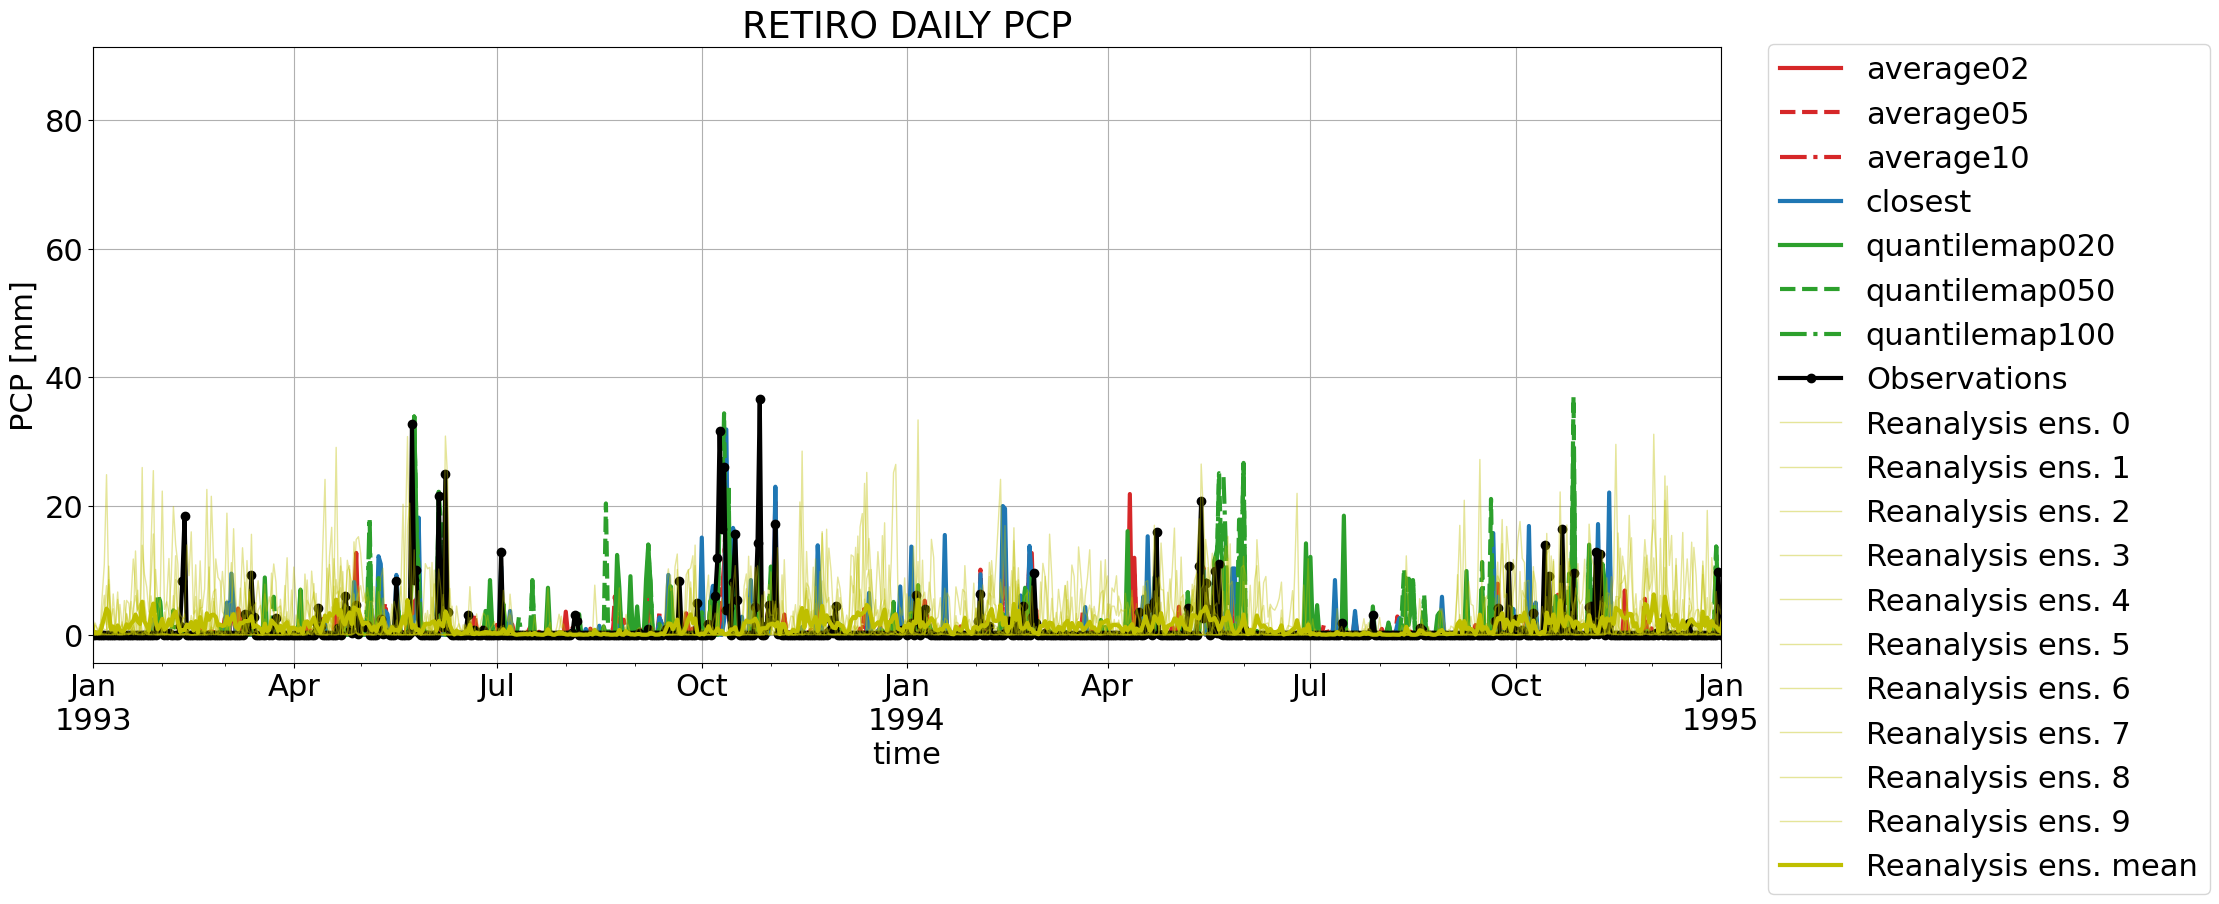

In [11]:
fig, ax = rskill.plotseries(start=datetime.datetime(1993, 1, 1), end=datetime.datetime(1995, 1, 1))
# fig, ax = rskill.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.2) Daily skill table

In [12]:
_, daily_skill = rskill.skill(threshold=1)

In [13]:
daily_skill

bias      rmse        r2       std  \
PCP_average02_reconstructions        0.00074  4.209285  0.284145  3.097212   
PCP_average05_reconstructions       0.022229   3.76094  0.352348  2.475913   
PCP_average10_reconstructions       0.032266  3.588103   0.39147  2.180188   
PCP_closest_reconstructions        -0.017022  4.881366  0.220807  3.867786   
PCP_quantilemap020_reconstructions -0.101314  4.165898  0.392965  3.559625   
PCP_quantilemap050_reconstructions  -0.06536  4.070335  0.420543  3.578051   
PCP_quantilemap100_reconstructions -0.049861  4.106225  0.423028  3.643565   
PCP_0_reanalysis                   -0.087841  4.841376  0.015124  2.940682   
PCP_1_reanalysis                    0.006455  4.726242  0.024365  2.803175   
PCP_2_reanalysis                    0.055959  4.689693  0.020876  2.793195   
PCP_3_reanalysis                    0.028387  4.702202   0.02106  2.841211   
PCP_4_reanalysis                   -0.018629  4.770626  0.010847  2.876163   
PCP_5_reanalysis                    0.064005  4.719325  0.006073   2.81086   
PCP_6_reanalysis                    0.022339  4.732178  0.028204    2.8858   
PCP_7_reanalysis                   -0.016214  4.726919  0.022487  2.916818   
PCP_8_reanalysis                    0.022429  4.721508  0.029653  2.881571   
PCP_9_reanalysis                    -0.01792  4.756212  0.020367  2.822552   
PCP_mean_reanalysis                 0.005897  3.915927  0.053374  1.059961   

                                          bs  
PCP_average02_reconstructions       0.212415  
PCP_average05_reconstructions       0.233644  
PCP_average10_reconstructions       0.241561  
PCP_closest_reconstructions         0.198495  
PCP_quantilemap020_reconstructions  0.191665  
PCP_quantilemap050_reconstructions  0.176570  
PCP_quantilemap100_reconstructions  0.174221  
PCP_0_reanalysis                    0.316513  
PCP_1_reanalysis                    0.307813  
PCP_2_reanalysis                    0.306421  
PCP_3_reanalysis                    0.302636  
PCP_4_reanalysis                    0.315338  
PCP_5_reanalysis                    0.305159  
PCP_6_reanalysis                    0.299504  
PCP_7_reanalysis                    0.312337  
PCP_8_reanalysis                    0.308813  
PCP_9_reanalysis                    0.309901  
PCP_mean_reanalysis                 0.468288

## 1.3) Daily Taylor diagram

(<Figure size 500x500 with 1 Axes>,
 <rascal.skill_evaluation.TaylorDiagram at 0x7f8e1a8f1580>)

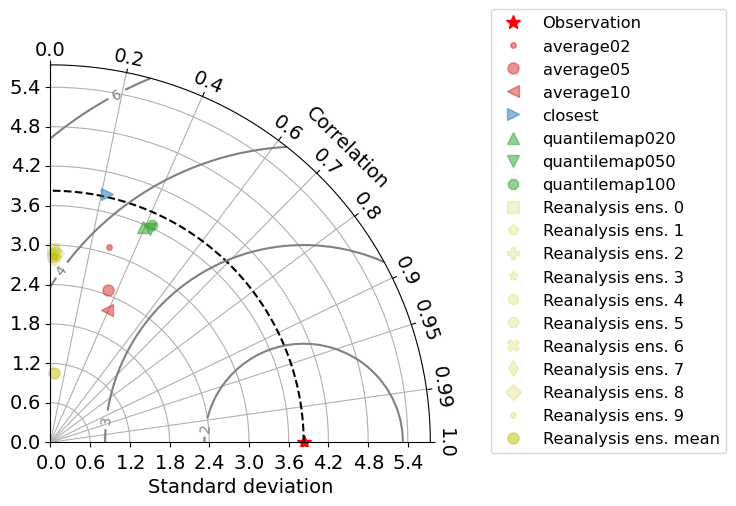

In [14]:
rskill.taylor()

## 1.4) Monthly time series

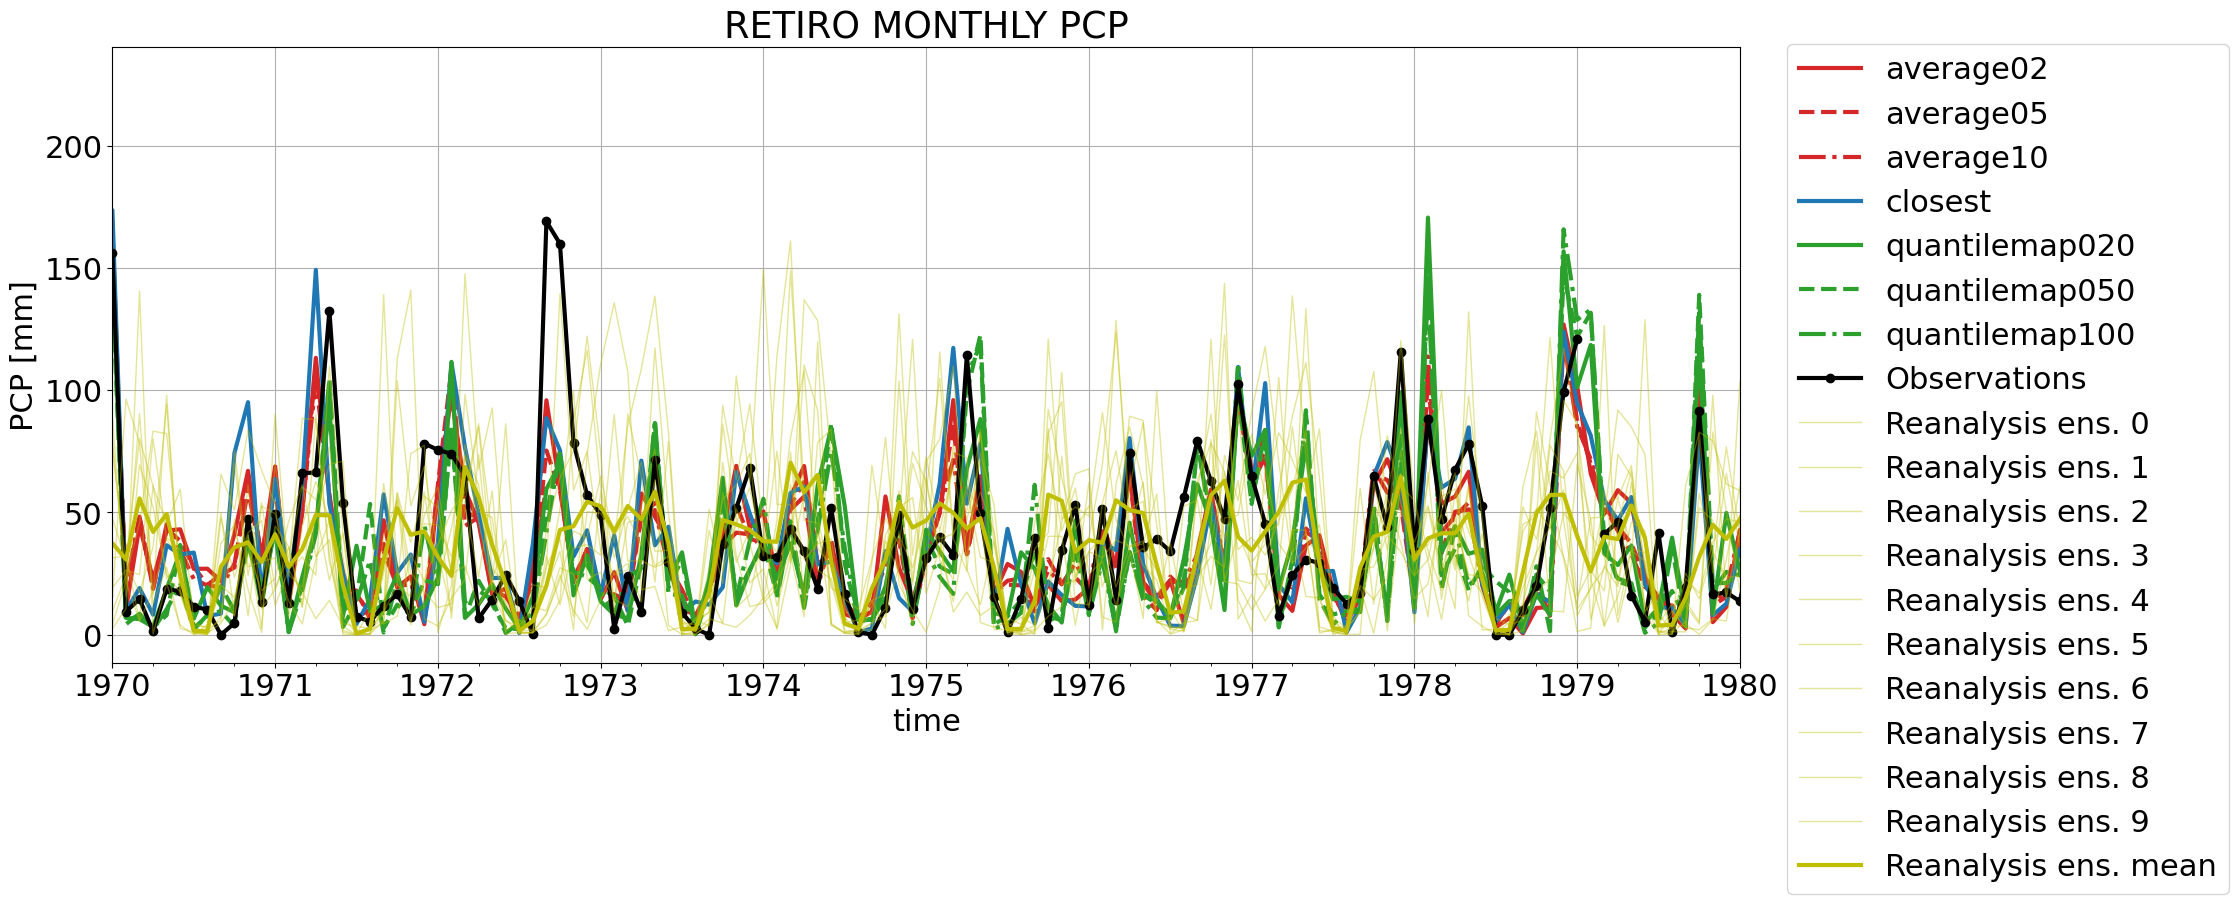

In [15]:
fig, ax = rskill_1m.plotseries(start=datetime.datetime(1970, 1, 1), end=datetime.datetime(1980, 1, 1))
# fig, ax = rskill_1m.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.5) Monthly skill table

In [16]:
_, monthly_skill = rskill_1m.skill()

In [17]:
monthly_skill

bias       rmse        r2        std  \
PCP_average02_reconstructions      -0.064354  26.647816  0.675494  30.668016   
PCP_average05_reconstructions       0.600374  24.570376  0.713317  28.798143   
PCP_average10_reconstructions       0.910578  23.593623   0.73263  27.649784   
PCP_closest_reconstructions        -0.588594  29.736236  0.629568  33.443995   
PCP_quantilemap020_reconstructions -3.106499  28.154484  0.672662  33.525152   
PCP_quantilemap050_reconstructions -1.992042  27.591527  0.696225  35.365676   
PCP_quantilemap100_reconstructions -1.515517  28.744798  0.681658  36.168299   
PCP_0_reanalysis                   -2.785985  42.956783  0.230146  33.041883   
PCP_1_reanalysis                    0.098552  41.409475  0.223562   31.18269   
PCP_2_reanalysis                    1.550664  41.131936  0.216945  31.318477   
PCP_3_reanalysis                    0.748191  41.640713  0.191502  32.084167   
PCP_4_reanalysis                   -0.704203  43.597838  0.151875  32.198782   
PCP_5_reanalysis                    1.833069  41.952787   0.17638  30.901609   
PCP_6_reanalysis                    0.534481  42.054664  0.215388  32.472617   
PCP_7_reanalysis                   -0.586191  43.388064  0.175062  33.235657   
PCP_8_reanalysis                    0.522323  41.475746  0.251887  32.714313   
PCP_9_reanalysis                   -0.674225  43.728524  0.149279    31.5372   
PCP_mean_reanalysis                 0.053667  33.531482  0.328253  19.151901   

                                             bs  
PCP_average02_reconstructions        710.106111  
PCP_average05_reconstructions        603.703398  
PCP_average10_reconstructions        556.659070  
PCP_closest_reconstructions          884.243714  
PCP_quantilemap020_reconstructions   792.674973  
PCP_quantilemap050_reconstructions   761.292387  
PCP_quantilemap100_reconstructions   826.263408  
PCP_0_reanalysis                    1845.285213  
PCP_1_reanalysis                    1714.744580  
PCP_2_reanalysis                    1691.836198  
PCP_3_reanalysis                    1733.949010  
PCP_4_reanalysis                    1900.771446  
PCP_5_reanalysis                    1760.036324  
PCP_6_reanalysis                    1768.594749  
PCP_7_reanalysis                    1882.524062  
PCP_8_reanalysis                    1720.237492  
PCP_9_reanalysis                    1912.183796  
PCP_mean_reanalysis                 1124.360254

## 1.6) Monthly Taylor diagram

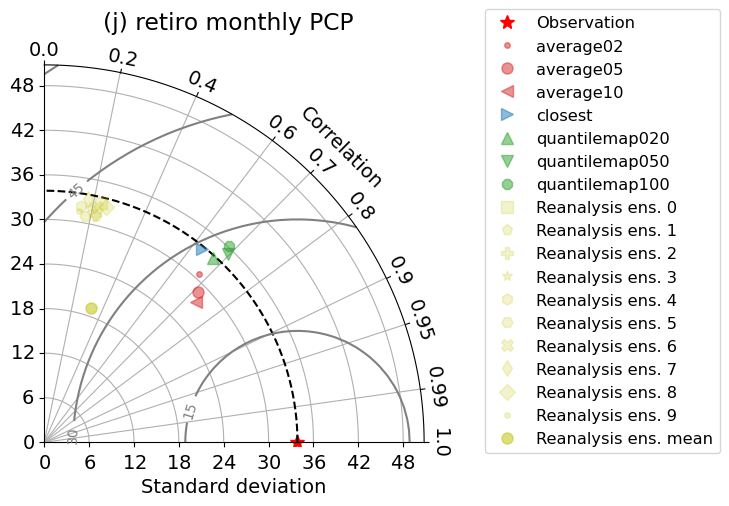

In [18]:
letter = {
    "avila": "(a) ",
    "colmenar": "(d) ",
    "navacerrada": "(g) ",
    "retiro": "(j) ",
    "segovia": "(m) "
}






fig, diag = rskill_1m.taylor()
fig.suptitle(letter[station_to_validate] + station_to_validate + " monthly " + variable_to_validate)

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_monthly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png",
    bbox_inches = 'tight'
)


## 1.7) Yearly time series

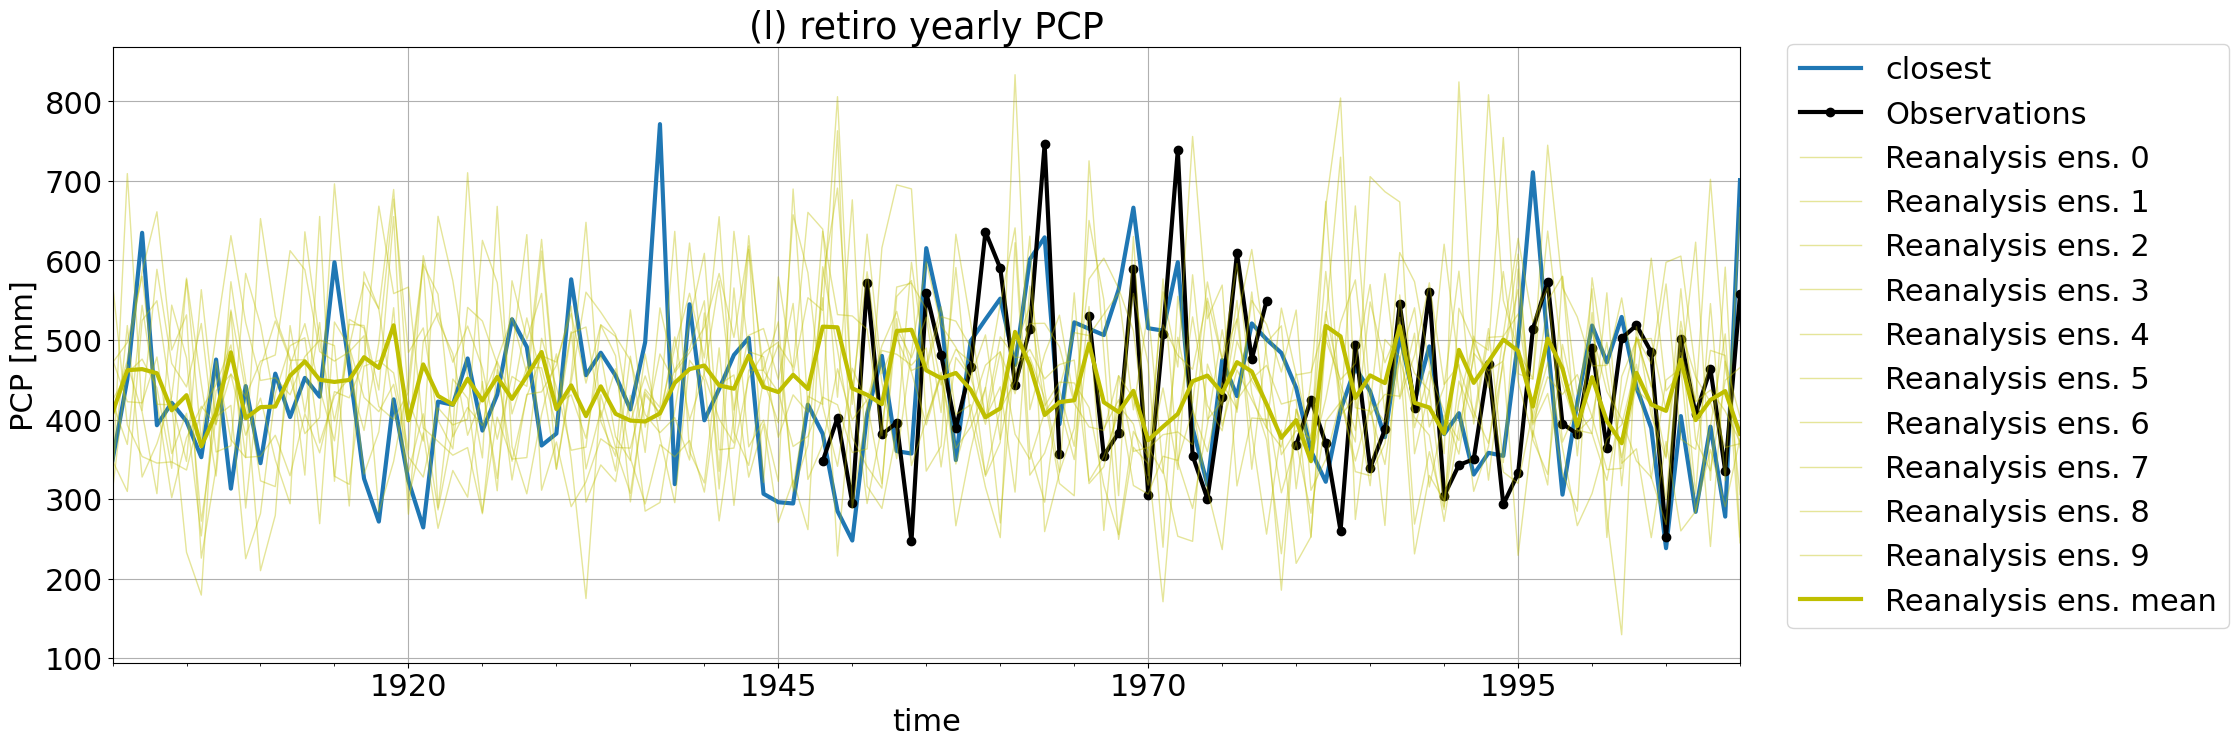

In [19]:
letter = {
    "avila": "(c) ",
    "colmenar": "(f) ",
    "navacerrada": "(i) ",
    "retiro": "(l) ",
    "segovia": "(o) "
}





fig, ax = rskill_1y.plotseries(start=initial_date, end=final_date, methods=[best_method[station_to_validate]])

ax.set_title(letter[station_to_validate] + station.name + " yearly " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/series_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

plt.show()

## 1.8) Yearly skill table

In [20]:
_, yearly_skill = rskill_1y.skill()

In [21]:
yearly_skill

bias        rmse        r2  \
PCP_average02_reconstructions        -0.08487   89.153169  0.649315   
PCP_average05_reconstructions         8.15158   86.572002  0.663408   
PCP_average10_reconstructions       11.422031   85.980215  0.663606   
PCP_closest_reconstructions         -6.432787   92.394997  0.646777   
PCP_quantilemap020_reconstructions -37.639344  118.131619  0.487612   
PCP_quantilemap050_reconstructions -25.001639  114.797108  0.491433   
PCP_quantilemap100_reconstructions -19.022951  120.898873  0.435155   
PCP_0_reanalysis                     -37.0095   163.62069 -0.105185   
PCP_1_reanalysis                     1.066951  167.969439  -0.16062   
PCP_2_reanalysis                    15.536242  169.505376 -0.256812   
PCP_3_reanalysis                     4.054962  175.294108  -0.08215   
PCP_4_reanalysis                    -8.336058  162.799569 -0.012198   
PCP_5_reanalysis                    20.460099   142.42972  0.158501   
PCP_6_reanalysis                     2.280498  155.165836 -0.001006   
PCP_7_reanalysis                    -7.713143  157.718141  -0.07223   
PCP_8_reanalysis                     4.645454  142.511495 -0.088028   
PCP_9_reanalysis                    -9.152559  167.374533 -0.056027   
PCP_mean_reanalysis                 -1.416705  126.332782 -0.165544   

                                           std            bs  
PCP_average02_reconstructions        94.540089   7948.287546  
PCP_average05_reconstructions        87.454621   7494.711462  
PCP_average10_reconstructions        80.910423   7392.597324  
PCP_closest_reconstructions         102.165967   8536.835410  
PCP_quantilemap020_reconstructions  111.998705  13955.079344  
PCP_quantilemap050_reconstructions  118.591721  13178.375902  
PCP_quantilemap100_reconstructions  120.737857  14616.537377  
PCP_0_reanalysis                      96.87035  26771.730323  
PCP_1_reanalysis                     99.115054  28213.732482  
PCP_2_reanalysis                    103.127934  28732.072563  
PCP_3_reanalysis                    117.650437  30728.024287  
PCP_4_reanalysis                    112.779135  26503.699622  
PCP_5_reanalysis                     98.692376  20286.225222  
PCP_6_reanalysis                    104.588875  24076.436792  
PCP_7_reanalysis                     99.930345  24875.011929  
PCP_8_reanalysis                     91.442482  20309.526254  
PCP_9_reanalysis                    108.087265  28014.234133  
PCP_mean_reanalysis                  37.394789  15959.971707

## 1.9) Yearly Taylor diagram

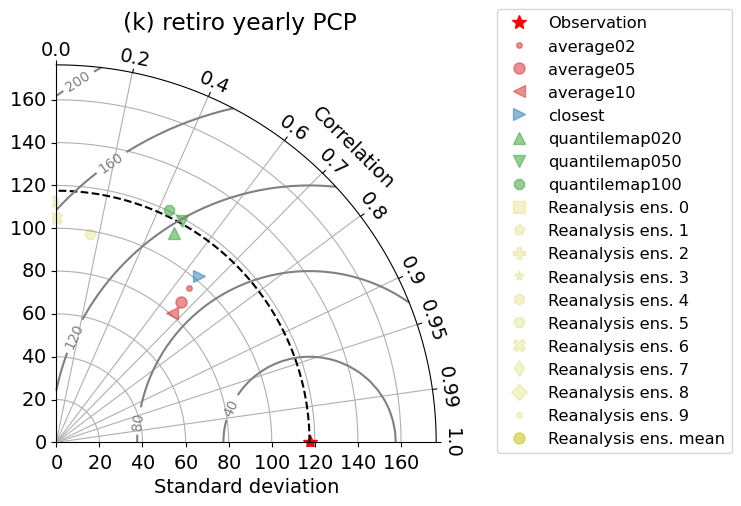

In [22]:
letter = {
    "avila": "(b) ",
    "colmenar": "(e) ",
    "navacerrada": "(h) ",
    "retiro": "(k) ",
    "segovia": "(n) "
}




fig, ax = rskill_1y.taylor()
fig.suptitle(letter[station_to_validate] + station_to_validate + " yearly " + variable_to_validate)

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)


# 2) SEASONALITY

## 2.1) Variable Annual Cycle

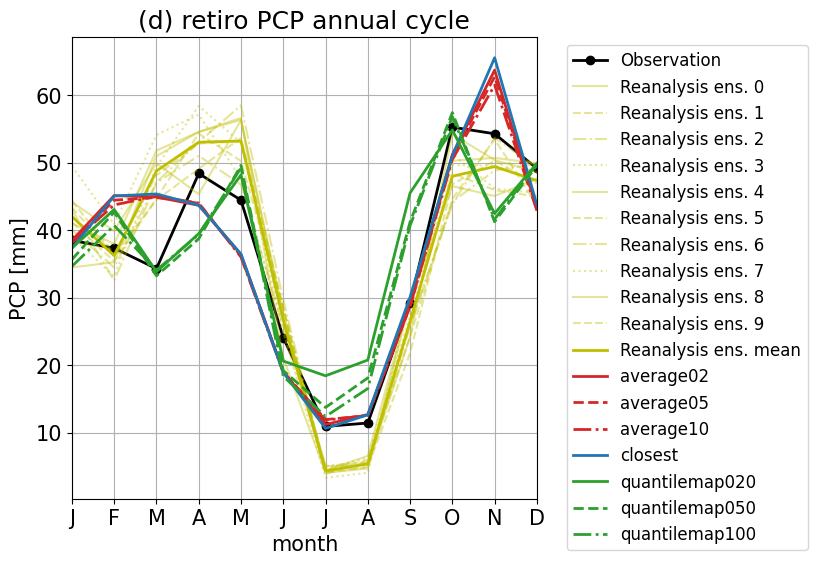

In [23]:
letter = {
    "avila": "(a) ",
    "colmenar": "(b) ",
    "navacerrada": "(c) ",
    "retiro": "(d) ",
    "segovia": "(e) "
}




fig, ax = rskill_1m.annual_cycle(grouping="mean")
ax.set_xlabel("month")
ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " annual cycle")
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_var_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

## 2.2) Variable Standard Deviation Annual Cycle

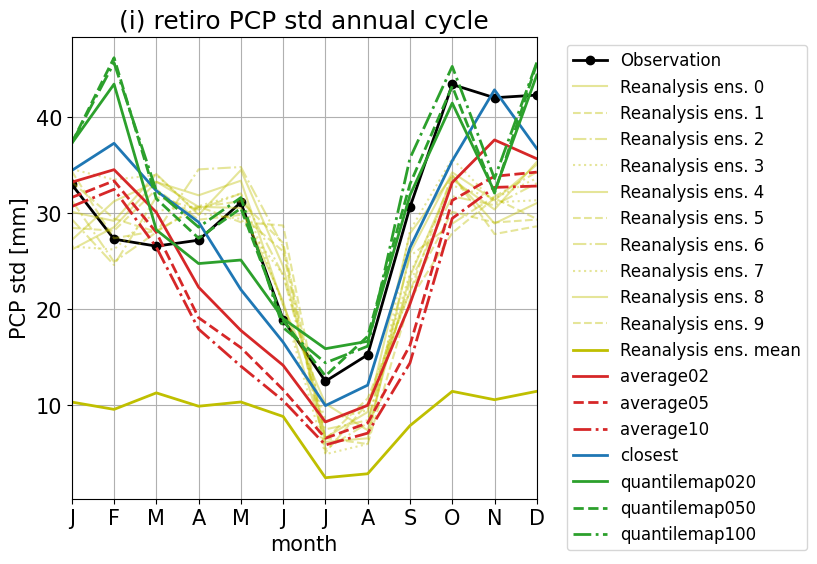

In [24]:
letter = {
    "avila": "(f) ",
    "colmenar": "(g) ",
    "navacerrada": "(h) ",
    "retiro": "(i) ",
    "segovia": "(j) "
}




fig, ax = rskill_1m.annual_cycle(grouping="std")
ax.set_xlabel("month")
ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " std annual cycle")
ax.set_ylabel(variable_to_validate + " std " + units[variable_to_validate])
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_std_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

# 3) DISTRIBUTIONS

## 3.1) Daily Quantile-Quantile Diagram

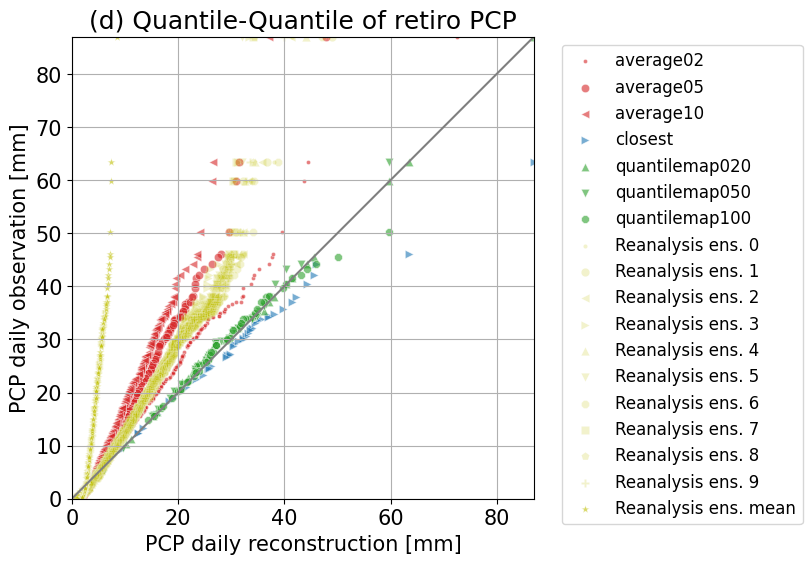

In [25]:
if variable_to_validate == "PCP":
    letter = {
    "avila": "(a) ",
    "colmenar": "(b) ",
    "navacerrada": "(c) ",
    "retiro": "(d) ",
    "segovia": "(e) "
    }
elif variable_to_validate == "TMAX":
    letter = {
    "avila": "(f) ",
    "colmenar": "(g) ",
    "navacerrada": "(h) ",
    "retiro": "(i) ",
    "segovia": "(j) "}
elif variable_to_validate == "TMIN":
    letter = {
    "avila": "(k) ",
    "colmenar": "(l) ",
    "navacerrada": "(m) ",
    "retiro": "(n) ",
    "segovia": "(o) "}


fig, ax = rskill.qqplot()
ax.set_title(letter[station_to_validate] + "Quantile-Quantile of " + station_to_validate + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/qq_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

# 4) INDICES

In [26]:
station_daily_thr = rascal.skill_evaluation.get_days_above_threshold(
    station_daily, 
    threshold=threshold, 
    inverse=inverse
)
reconstructions_daily_thr = rascal.skill_evaluation.get_days_above_threshold(
    reconstructions_daily, 
    threshold=threshold, 
    inverse=inverse
)
reanalysis_daily_thr = rascal.skill_evaluation.get_days_above_threshold(
    reanalysis_daily, 
    threshold=threshold, 
    inverse=inverse
)


# Daily data 
thrskill = rascal.skill_evaluation.RSkill(
    observations=station_daily_thr,
    reconstructions=reconstructions_daily_thr,
    reanalysis=reanalysis_daily_thr
)

# Monthly data
thrskill_1m = thrskill.resample(freq="1m", grouping="sum", hydroyear=hydroyear, skipna=False)

# Yearly data
thrskill_1y = thrskill.resample(freq="1Y", grouping="sum", hydroyear=hydroyear, skipna=False)

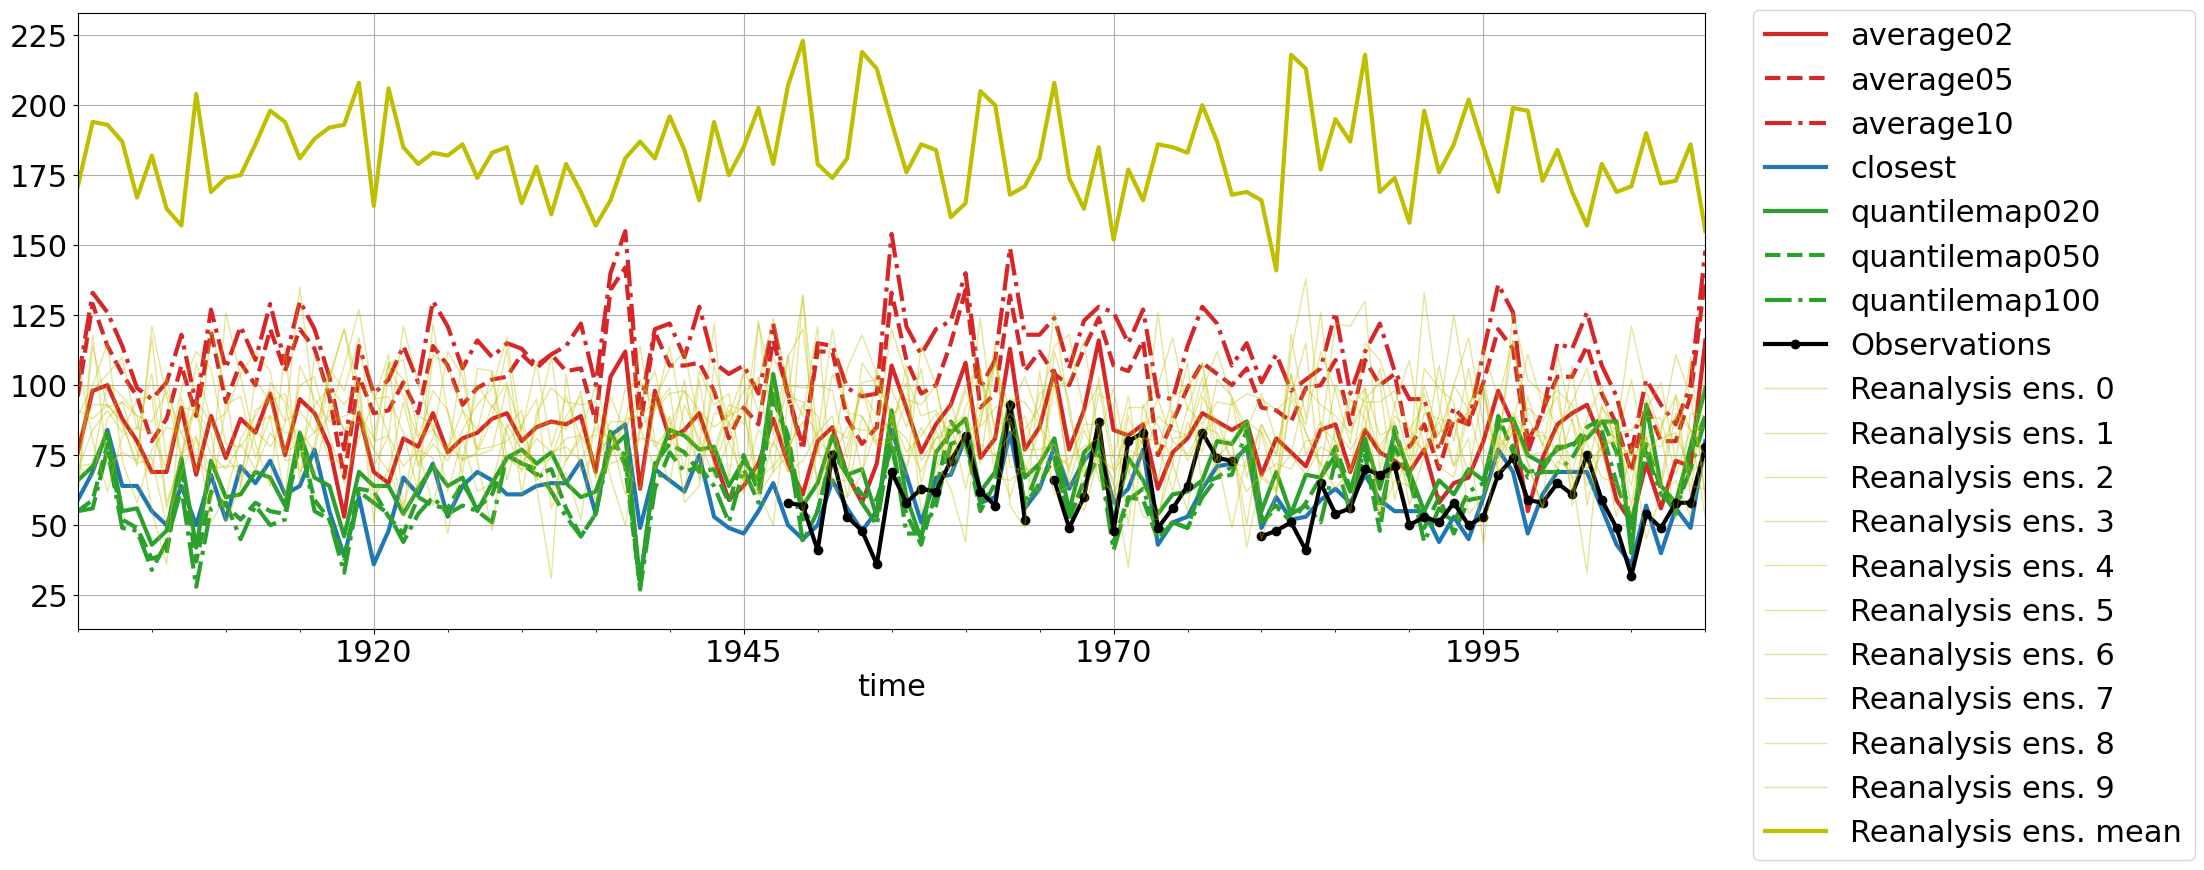

In [27]:
fig, ax = thrskill_1y.plotseries(start=initial_date, end=final_date)

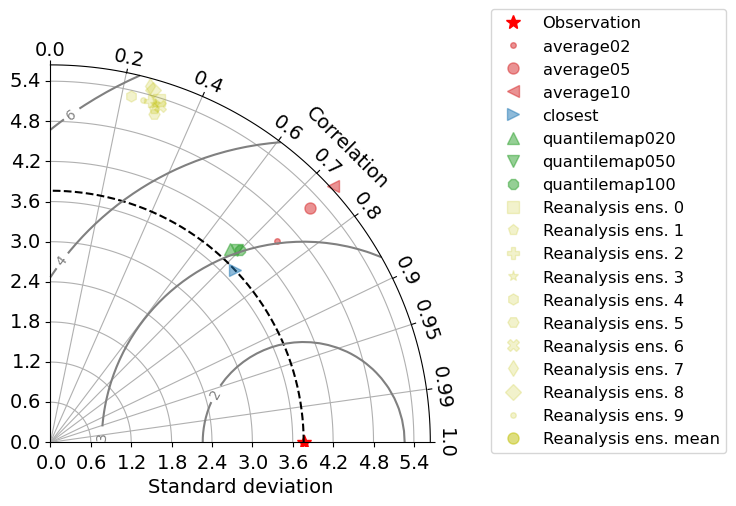

In [28]:
fig, ax = thrskill_1m.taylor()

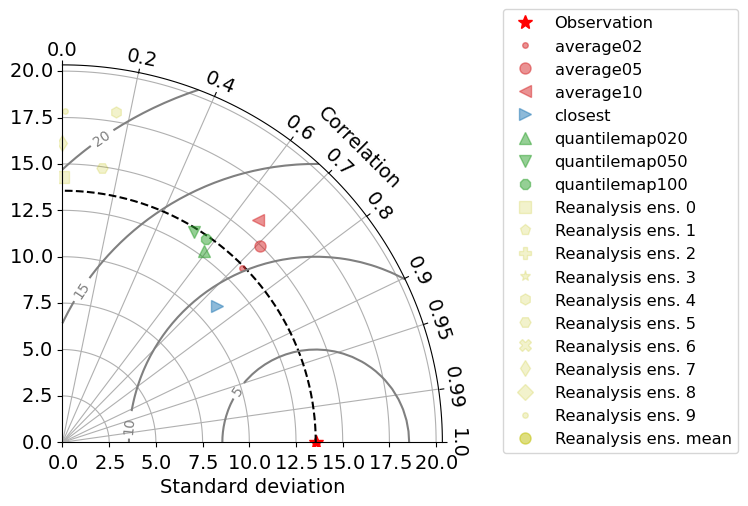

In [29]:
fig, ax = thrskill_1y.taylor()

### 6.1) Monthly days above certain threshold 

In [30]:
if variable_to_validate == "PCNR":
    threshold = 1
    inverse = False
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    threshold = 0
    inverse = True

extended_daily_ensemble = daily_ensemble.copy()     
extended_daily_ensemble["observations"] = station_data_daily
extended_daily_ensemble["reanalysis"] = reanalysis_data_daily


days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="m",
    inverse=inverse
)


NameError: name 'daily_ensemble' is not defined

In [ ]:
days_above_threshold

In [ ]:
if inverse:
   threshold_label = "BELOW " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "") 
else:
   threshold_label = "ABOVE " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "")  

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [ ]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_monthly_std, threshold_monthly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [ ]:
threshold_monthly_skill

In [ ]:
rascal.skill_evaluation.taylor_test(threshold_monthly_std, threshold_monthly_skill)

### 6.2) Yearly days above certain threshold 

In [ ]:
days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="Y",
    inverse=inverse
)


In [ ]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [ ]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_yearly_std, threshold_yearly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [ ]:
threshold_yearly_skill

In [ ]:
rascal.skill_evaluation.taylor_test(threshold_yearly_std, threshold_yearly_skill)

### 6.3) Seasonal Skill Table

In [ ]:
seasons = [
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11]
]
seasons_name = [
    "DJF",
    "MAM",
    "JJA",
    "SON"
]


fig1 = plt.figure(figsize=(20, 4))
ax1 = fig1.subplots(1, 4)

fig2 = plt.figure(figsize=(20, 4))
ax2 = fig2.subplots(1, 4)

fig3 = plt.figure(figsize=(20, 4))
ax3 = fig3.subplots(1, 4)

for i, season in enumerate(seasons):
    seasonal_observation = station_data_daily.loc[station_data_daily.index.month.isin(season)]
    seasonal_reanalysis = reanalysis_data_daily.loc[reanalysis_data_daily.index.month.isin(season)]
    seasonal_ensemble = {}
    for k, v in daily_ensemble.items():
        seasonal_ensemble[k] = v.loc[v.index.month.isin(season)]

    _, seasonal_skill = rascal.skill_evaluation.get_skill(
        observation=seasonal_observation, 
        simulations=seasonal_ensemble,
        variable=variable_to_validate,
        reference_model=seasonal_reanalysis,
        threshold=threshold
    )"lightgrey""lightgrey"
    
    seasonal_skill.index.name = "model"
    seasonal_skill = seasonal_skill.reset_index()
    seasonal_skill["method"] = seasonal_skill["model"].apply(lambda x: re.sub(r'[0-9]', '', x))

    
    p1 = sns.barplot(data=seasonal_skill, x="model", y="hss", ax=ax1[i], hue="method")
    p1.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    p1.set_ylim(-1, 1)
    ax1[i].set_title(seasons_name[i])
    ax1[i].get_legend().remove()
    
    p2 = sns.barplot(data=seasonal_skill, x="model", y="bs", ax=ax2[i], hue="method")
    p2.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax2[i].set_title(seasons_name[i])
    ax2[i].get_legend().remove()
        
    p3 = sns.barplot(data=seasonal_skill, x="model", y="ssmse", ax=ax3[i], hue="method")
    p3.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax3[i].set_title(seasons_name[i])
    ax3[i].get_legend().remove()
        
plt.show()
